# 0. Change and mount Google Drive if exist

In [1]:
import os
 
# if exist, connect to Google Drive on Colab jupyter notebook
if os.path.exists('/content/drive/MyDrive/git/tensortrade-train'):
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')
elif os.path.exists('/content'):
  from google.colab import drive
  drive.mount('/content/drive')
 
  # Change the current working directory
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')
 
# Print the current working directory
print("Working directory: {0}".format(os.getcwd()))

Working directory: C:\git\dennislee\tensortrade-train


## 0.1 Clone/pull repo

In [2]:
if not os.path.isdir(os.getcwd()+'/.git'):
  !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
else:  # repo already exists, update it
  !git pull origin master

fatal: unable to access 'https://github.com/dennislwy/tensortrade-train.git/': Couldn't connect to server


## 0.2 Install dependencies
Check GPU availability

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0 or gpu_info.find('not found')>=0)
gpu_count = 0
if gpu_available:
  print('GPU available')
  print(gpu_info)
  gpu_count = 1
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Install requirements

In [5]:
if gpu_available:
  print("Installing GPU requirement packages")
  !pip install -r requirements.ray.txt
else:
  print("Installing non-GPU requirement packages")
  !pip install -r requirements.ray.no-gpu.txt

Installing non-GPU requirement packages
  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-iu5bkuw5
  Running command git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-iu5bkuw5
  fatal: unable to access 'https://github.com/tensortrade-org/tensortrade.git/': Couldn't connect to server
ERROR: Command errored out with exit status 128: git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-iu5bkuw5 Check the logs for full command output.


## Imports

In [6]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default

%matplotlib inline

2021-07-26 09:08:08.882537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-26 09:08:08.882556: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Preparation
### Load data

In [8]:
# sample sine wave data path
sine_fixed_data_path = 'data/inputs/sine-fixed-15m-btc-usdt.csv'
sine_down_data_path = 'data/inputs/sine-down-15m-btc-usdt.csv'
sine_up_data_path = 'data/inputs/sine-up-15m-btc-usdt.csv'

# binance data path
from tradingview import load_tradingview_csv
binance_15m_data_path = 'data/inputs/binance-15m-20210512-20200726.csv'
binance_1h_data_path = 'data/inputs/binance-1h-20210512-20210726.csv'
binance_1d_data_path ='data/inputs/binance-1d-btc-usdt.csv'

In [9]:
def load_data(data_path):
  df = pd.read_csv(data_path)
  df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
  df['date'] = pd.to_datetime(df['date'])
  return df

In [10]:
def generate_sine_series(offset=3300, amplitude=300, steps=1000, cycle=3):
    x = np.arange(0, 2*np.pi, 2*np.pi / (steps+1))
    y = amplitude*np.sin(cycle*x) + offset
    return [x, y]

def generate_sine_data(offset=3300, amplitude=300, steps=1000, cycle=3):
  df = pd.DataFrame()
  [x, y] = generate_sine_series(offset, amplitude, steps, cycle)
  df['close'] = y
  return df

In [11]:
sample_data = [
#     {
#       "dataframe": generate_sine_data(offset=33000, amplitude=3000, steps=1000, cycle=3),
#       "expriment_name": "sinewave1",
#       "reward_mean_target": 33517.4
#     },
    {
      "dataframe": load_data(sine_fixed_data_path),
      "name": "sine_fixed",
      "reward_target_fraction": 0.947519
    },
    {
      "dataframe": load_data(sine_up_data_path),
      "name": "sine_up",
      "reward_target_fraction": 0.947519
    },
    {
      "dataframe": load_tradingview_csv(binance_15m_data_path),
      "name": "binance_15m",
      "reward_target_fraction": 0.75
    },
    {
      "dataframe": load_tradingview_csv(binance_1h_data_path),
      "name": "binance_1h",
      "reward_target_fraction": 0.45
    },
    {
      "dataframe": load_data(binance_1d_data_path),
      "name": "binance_1d",
      "reward_target_fraction": 0.9
    },
]

In [12]:
from transform import difference

def calc_est_max_reward(df):
    temp = df.copy()
    temp['close_diff'] = difference(temp['close'], inplace=False)
    return round(temp['close_diff'].abs().sum(), 1)

<AxesSubplot:>

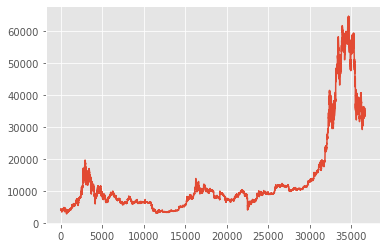

In [13]:
selected_dataset_index = 3
experiment_name = 'binance-1h-1'

selected_sample = sample_data[selected_dataset_index]
df = selected_sample['dataframe']
reward_target_fraction = selected_sample['reward_target_fraction']

df['close'].plot(grid=True)

In [14]:
df = df.head(int(len(df)*0.7))
#df = df.tail(int(len(df)*0.5))

<AxesSubplot:>

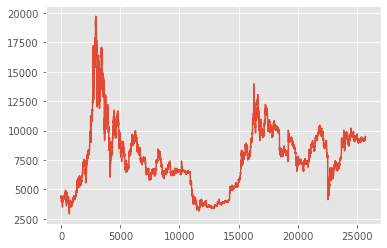

In [15]:
df['close'].plot(grid=True)

In [16]:
print(f"Experiment name: '{experiment_name}'")
print(f"Dataset length: {len(df)}")
est_max_reward = calc_est_max_reward(df)
print(f"Estimated max. reward: {est_max_reward}")
reward_mean_target = round(est_max_reward * reward_target_fraction, 2)
print(f"Reward target fraction: {reward_target_fraction}")
print(f"Reward mean target: {reward_mean_target}")
df

Experiment name: 'binance-1h-1'
Dataset length: 25697
Estimated max. reward: 1172631.5
Reward target fraction: 0.45
Reward mean target: 527684.18


,date,open,high,low,close,volume
0,2017-08-17 04:00:00,16199.91,16199.91,4261.32,4308.83,190952.85
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,100304.82
2,2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,31282.31
3,2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,19241.06
4,2017-08-17 08:00:00,4349.99,4377.85,4333.32,4360.69,4139.70
...,...,...,...,...,...,...
25692,2020-07-22 20:00:00,9373.88,9385.44,9364.98,9367.71,12438246.81
25693,2020-07-22 21:00:00,9367.71,9378.22,9360.00,9374.25,11305162.51
25694,2020-07-22 22:00:00,9374.25,9544.00,9368.75,9500.00,80419399.00
25695,2020-07-22 23:00:00,9500.00,9533.00,9498.66,9518.16,29638572.32


## Load other data set for evaluation testing

In [17]:
df_sine_fixed = load_data(sine_fixed_data_path)
df_sine_up = load_data(sine_up_data_path)
df_sine_down = load_data(sine_down_data_path)
df_binance_1d = load_data(binance_1d_data_path)
df_binance_1h = load_data(binance_1h_data_path)
df_binance_15m = load_data(binance_15m_data_path)

<AxesSubplot:>

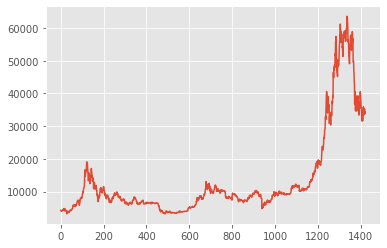

In [18]:
df_binance_1d['close'].plot(grid=True)

<AxesSubplot:>

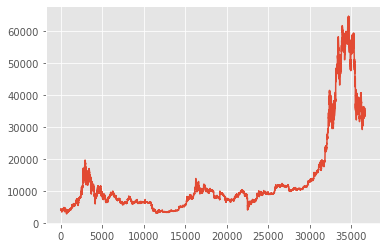

In [19]:
df_binance_1h['close'].plot(grid=True)

<AxesSubplot:>

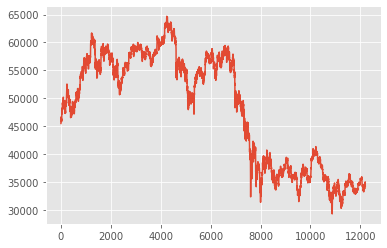

In [20]:
df_binance_15m['close'].plot(grid=True)

### Create the dataset features

In [21]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def diff_norm(series_fast, series_slow):
    return 1-series_slow/series_fast
    
def add_indicators(df, fillna=False):
    if 'date' in df:
        df['time_of_day'] = (df['date'].dt.hour*60 + df['date'].dt.minute)/1440
        df['day_of_week'] = df['date'].dt.dayofweek/6

    df['close_diff'] = difference(df['close'], inplace=False)  # CD
    #df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    #df['close_mean'] = mean_normalize(df['close'], inplace=False)
   
    df['ema5'] = ema_indicator(df['close'], 5, fillna=fillna)  #E5
    df['ema5_diff'] = difference(df['ema5'], inplace=False)  #E5D

    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)  #E10
    #df['ema10_diff'] = difference(df['ema10'], inplace=False)  #E10D

    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)  #E25
    #df['ema25_diff'] = difference(df['ema25'], inplace=False)  #E25D

    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)  #E50
    #df['ema50_diff'] = difference(df['ema50'], inplace=False)  #E50D
    
    df['ema120'] = ema_indicator(df['close'], 120, fillna=fillna)  #E120
    #df['ema120_diff'] = difference(df['ema120'], inplace=False)  #E120D

    df['ema5_10_diff'] = df['ema5']-df['ema10']  #ED5_10
    df['ema5_10_diff_norm'] = diff_norm(df['ema5'], df['ema10'])  #EDN5_10
    df['trend_ema5_10'] = np.where(df['ema5_10_diff_norm']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']  #ED10_25
    df['ema10_25_diff_norm'] = diff_norm(df['ema10'], df['ema25'])  #EDN10_25
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)
    
    df['ema25_50_diff'] = df['ema25']-df['ema50']  #ED25_50
    df['ema25_50_diff_norm'] = diff_norm(df['ema25'], df['ema50'])  #EDN25_50
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema50_120_diff'] = df['ema50']-df['ema120']  #ED50_120
    df['ema50_120_diff_norm'] = diff_norm(df['ema50'], df['ema120'])  #EDN50_120
    df['trend_ema50_120'] = np.where(df['ema50_120_diff']>0, 1, -1)

    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)  # MACD
    df['trend_macd'] = np.where(df['macd_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [22]:
# add indicators to all dataset
add_indicators(df, fillna=False)
add_indicators(df_sine_fixed, fillna=False)
add_indicators(df_sine_up, fillna=False)
add_indicators(df_sine_down, fillna=False)
add_indicators(df_binance_15m, fillna=False)
add_indicators(df_binance_1d, fillna=False)
add_indicators(df_binance_1h, fillna=False)
df

/home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,date,open,high,low,close,volume,time_of_day,day_of_week,close_diff,ema5,...,ema10_25_diff_norm,trend_ema10_25,ema25_50_diff,ema25_50_diff_norm,trend_ema25_50,ema50_120_diff,ema50_120_diff_norm,trend_ema50_120,macd_diff,trend_macd
0,2017-08-22 03:00:00,3849.98,3862.39,3802.53,3862.39,61001.83,0.125000,0.166667,12.41,3860.009819,...,-0.017868,-1,-54.332129,-0.013672,-1,-85.251757,-0.021163,-1,-18.010001,-1
1,2017-08-22 04:00:00,3862.39,3868.57,3450.98,3500.80,104276.67,0.166667,0.166667,-361.59,3740.273213,...,-0.027854,-1,-70.041690,-0.017788,-1,-95.808885,-0.023907,-1,-37.484919,-1
2,2017-08-22 05:00:00,3500.80,3695.62,3400.00,3626.99,50315.10,0.208333,0.166667,126.19,3702.512142,...,-0.031598,-1,-79.004568,-0.020187,-1,-102.859407,-0.025762,-1,-39.210533,-1
3,2017-08-22 06:00:00,3626.99,3854.46,3619.95,3803.00,207669.07,0.250000,0.166667,176.01,3736.008094,...,-0.028899,-1,-80.078344,-0.020506,-1,-105.461702,-0.026463,-1,-26.452003,-1
4,2017-08-22 07:00:00,3803.00,3803.00,3733.80,3798.08,233056.82,0.291667,0.166667,-4.92,3756.698730,...,-0.026600,-1,-80.974609,-0.020779,-1,-107.963879,-0.027141,-1,-16.770155,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25573,2020-07-22 20:00:00,9373.88,9385.44,9364.98,9367.71,12438246.81,0.833333,0.333333,-6.17,9361.581664,...,0.001323,1,30.434531,0.003258,1,55.089635,0.005917,1,1.224809,1
25574,2020-07-22 21:00:00,9367.71,9378.22,9360.00,9374.25,11305162.51,0.875000,0.333333,6.54,9365.804443,...,0.001459,1,30.508490,0.003265,1,55.632100,0.005974,1,1.768387,1
25575,2020-07-22 22:00:00,9374.25,9544.00,9368.75,9500.00,80419399.00,0.916667,0.333333,125.75,9410.536295,...,0.002943,1,35.223755,0.003765,1,58.961478,0.006326,1,9.943150,1
25576,2020-07-22 23:00:00,9500.00,9533.00,9498.66,9518.16,29638572.32,0.958333,0.333333,18.16,9446.410863,...,0.004218,1,39.984130,0.004268,1,62.481191,0.006698,1,15.583652,1


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [23]:
if 'volume' in df:
  price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
else:
  price_history = df[['close']]

display(price_history.head(3))

,date,open,high,low,close,volume
0,2017-08-22 03:00:00,3849.98,3862.39,3802.53,3862.39,61001.83
1,2017-08-22 04:00:00,3862.39,3868.57,3450.98,3500.80,104276.67
2,2017-08-22 05:00:00,3500.80,3695.62,3400.00,3626.99,50315.10


<AxesSubplot:>

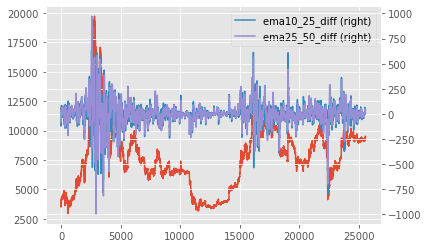

In [24]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [25]:
!pip install mplfinance

## Make a copy of the dataset

In [26]:
if 'volume' in df:
  import mplfinance as mpf
  cd = df.copy()  
  #cd = cd.head(int(len(cd)*0.5))

  # total data length in dataset
  data_length = len(cd)
  print(f"Total data length: {data_length}")

  cd.set_index('date', inplace=True)

Total data length: 25578


# Plot Price History Chart

/home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


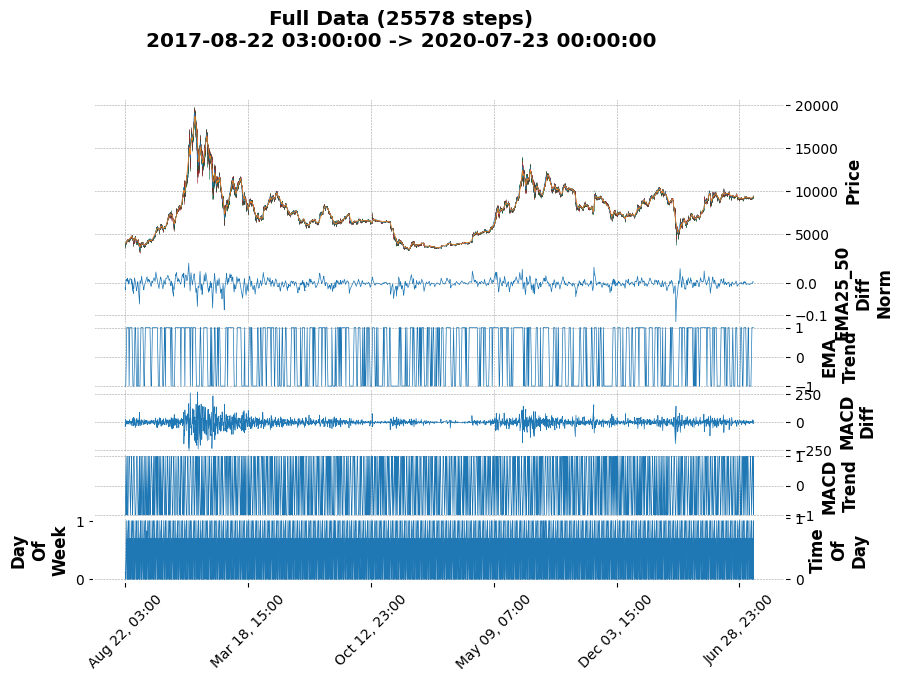

In [27]:
if 'volume' in df:
  overlays = cd[['ema25', 'ema50']]
  apds = [ 
          mpf.make_addplot(overlays, width=0.5), 
          mpf.make_addplot(cd['ema25_50_diff_norm'], panel=1, width=0.5, ylabel='EMA25_50\nDiff\nNorm'),
          mpf.make_addplot(cd['trend_ema25_50'], panel=2, width=0.5, ylabel='EMA\nTrend'),
          mpf.make_addplot(cd['macd_diff'], panel=3, width=0.5, ylabel='MACD\nDiff'),
          mpf.make_addplot(cd['trend_macd'], panel=4, width=0.5, ylabel='MACD\nTrend'),
          mpf.make_addplot(cd['time_of_day'], panel=5, width=0.5, ylabel='Time\nOf\nDay'),
          mpf.make_addplot(cd['day_of_week'], panel=5, width=0.5, ylabel='Day\nOf\nWeek'),
        ]
  mpf.plot(cd, type='candle', 
          title='Full Data (%d steps)\n%s -> %s'  % (data_length, cd.index[0], cd.index[data_length-1]),
          style='charles', volume=False, 
          addplot=apds, figscale=1.2)

In [28]:
import matplotlib.pyplot as plt

def show_chart(title, df, columns1, columns2, columns3, columns4):
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[0], grid=True, secondary_y=True)
    df[columns3].plot(ax=axs[1], grid=True)
    df[columns4].plot(ax=axs[2], grid=True)

In [29]:
columns1 = ['close']
columns2 = ['close_diff']
columns3 = ['ema5_10_diff', 'ema10_25_diff', 'ema25_50_diff']
# columns4 = ['trend_ema10_25', 'trend_ema25_50', 'ema10_25_diff_norm', 'ema25_50_diff_norm']
columns4 = ['ema5_10_diff_norm', 'ema10_25_diff_norm', 'ema25_50_diff_norm']

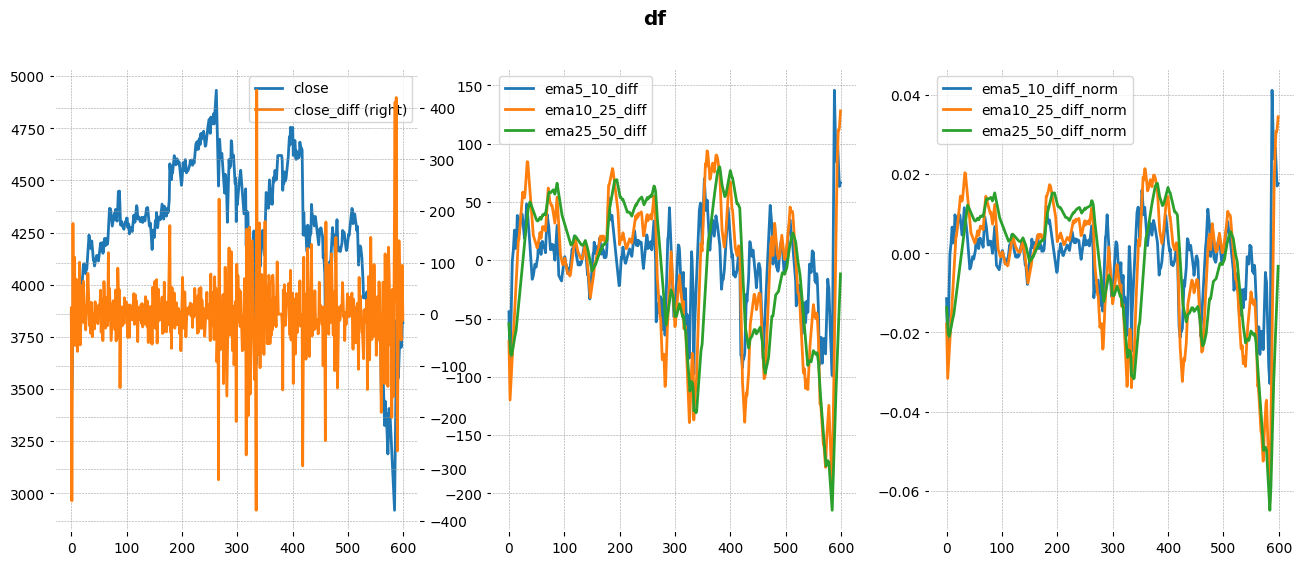

In [30]:
show_chart('df', df.head(600), columns1, columns2, columns3, columns4)

### Create Streams

In [31]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [32]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

### Setup Environment

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        title: str = kwargs.get('title', None)
        filename: str = kwargs.get('filename', None)
            
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)


        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            
        if title:
            fig.suptitle(title)
        else:
            fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        performance_df.net_worth.plot(ax=axs[0], secondary_y=True, grid=True, legend=True)

        if filename:
            plt.savefig(filename, transparent=False, bbox_inches='tight')
            
        plt.show()


In [34]:
def get_exchange(stream):
    return Exchange("bitfinex", service=execute_order)(
        stream
    )

def get_cash_asset(exchange, initial_capital=1000):
    return [
        Wallet(exchange, initial_capital * USD), 
        Wallet(exchange, 0 * TTC)
    ]

initial_capital = 1000

In [35]:
def create_env(config):  
    df = config['df']
    
    p = Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC")
  
    bitfinex = get_exchange(p)
    
    [cash, asset] = get_cash_asset(bitfinex, initial_capital)

    portfolio = Portfolio(USD, [cash, asset])
    
    reward_scheme = default.rewards.PBR(price=p)
    action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'].tolist(), dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])
    
#     feed = DataFeed([
#         p,
#         p.rolling(window=10).mean().rename("fast"),
#         p.rolling(window=50).mean().rename("medium"),
#         p.rolling(window=100).mean().rename("slow"),
#         p.log().diff().fillna(0).rename("lr")
#     ])
    
    feed = DataFeed([
        #p,
        #p.rolling(window=10).mean().rename("fast"),
        #p.rolling(window=50).mean().rename("medium"),
        #p.rolling(window=100).mean().rename("slow"),
        #p.log().diff().fillna(0).rename("lr")
        
        Stream.source(df['time_of_day'].tolist(), dtype="float").rename("time_of_day"),
        Stream.source(df['day_of_week'].tolist(), dtype="float").rename("day_of_week"),
        
        #Stream.source(df['open'].tolist(), dtype="float").rename("open"),
        #Stream.source(df['high'].tolist(), dtype="float").rename("high"),
        #Stream.source(df['low'].tolist(), dtype="float").rename("low"),
        #Stream.source(df['close'].tolist(), dtype="float").rename("close"),
        #Stream.source(df['volume'].tolist(), dtype="float").rename("volume"),

        #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
        Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

        #Stream.source(df['ema5'].tolist(), dtype="float").rename("ema5"),
        #Stream.source(df['ema10'].tolist(), dtype="float").rename("ema10"),
        #Stream.source(df['ema25'].tolist(), dtype="float").rename("ema25"),
        #Stream.source(df['ema50'].tolist(), dtype="float").rename("ema50"),
        #Stream.source(df['ema120'].tolist(), dtype="float").rename("ema120"),
        
        Stream.source(df['ema5_10_diff_norm'].tolist(), dtype="float").rename("ema5_10_diff_norm"),
        Stream.source(df['ema10_25_diff_norm'].tolist(), dtype="float").rename("ema10_25_diff_norm"),
        Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
        Stream.source(df['ema50_120_diff_norm'].tolist(), dtype="float").rename("ema50_120_diff_norm"),
        
        #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

        #Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
        #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
        #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

        Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

## Locate Last Checkpoint (if exist)

In [36]:
import os
from typing import List

# https://github.com/ray-project/ray/issues/4569#issuecomment-809543802
def retrieve_checkpoint(path: str = "data/results", prefix: str = "train_fn") -> str:
    """Returns a latest checkpoint unless there are none, then it returns None."""
    def all_dirs_under(path):
        """Iterates through all files that are under the given path."""
        for cur_path, dirnames, filenames in os.walk(path):
            for dir_ in dirnames:
                yield os.path.join(cur_path, dir_)

    def retrieve_checkpoints(paths: List[str]) -> List[str]:
        checkpoints = list()
        for path in paths:
            for cur_path, dirnames, _ in os.walk(path):
                for dirname in dirnames:
                    if dirname.startswith("checkpoint_"):
                        checkpoints.append(os.path.join(cur_path, dirname))
        return checkpoints

    sorted_checkpoints = retrieve_checkpoints(
        sorted(
            filter(
                lambda x: x.startswith(path + "/" + prefix), all_dirs_under(path)
            ),
            key=os.path.getmtime
        )
    )[::-1]
    
    best_checkpoint = None
    best_checkpoint_iter = 0
    
    for checkpoint in sorted_checkpoints:
        if checkpoint is not None and 'checkpoint' in checkpoint:
            checkpoint_iter = int(checkpoint.rsplit('_', 1)[1])
            checkpoint_filepath = checkpoint + '/checkpoint-' + checkpoint.split('_')[-1]
            if checkpoint_iter > best_checkpoint_iter and os.path.isfile(checkpoint_filepath):
                best_checkpoint_iter = checkpoint_iter
                best_checkpoint = checkpoint_filepath

    return best_checkpoint 

In [37]:
lastest_checkpoint_path = retrieve_checkpoint(path="data/results", prefix=experiment_name)
print(f"Latest checkpoint = '{lastest_checkpoint_path}'")

Latest checkpoint = 'data/results/binance-1h-1/PPO_TradingEnv_0_2021-07-25_18-20-10411mq44p/checkpoint_9720/checkpoint-9720'


## Setup and Train Agent

In [38]:
import os
import ray
from ray import tune
from ray.tune.registry import register_env
 
register_env("TradingEnv", create_env)

analysis = tune.run(
    "PPO",
    name=experiment_name,
    stop={
      "episode_reward_mean": reward_mean_target
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "log_level": "INFO",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01,
        "vf_clip_param": est_max_reward
    },
    #resume=True,
    restore=lastest_checkpoint_path,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    keep_checkpoints_num=2,
    local_dir="data/results"
)

2021-07-26 09:08:14,023	INFO resource_spec.py:223 -- Starting Ray with 6.69 GiB memory available for workers and up to 3.35 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-07-26 09:08:14,477	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_f5013_00000,RUNNING,


(pid=256804) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=256804) Instructions for updating:
(pid=256804) non-resource variables are not supported in the long term
(pid=256804) 2021-07-26 09:08:17,888	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fb479be8bb0>}
(pid=256804) 2021-07-26 09:08:17,888	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fb479be8f10>}
(pid=256804) 2021-07-26 09:08:17,888	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 8), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=256804) 2021-07-26 09:0

(pid=256802) 2021-07-26 09:08:21,663	INFO sample_batch_builder.py:202 -- Trajectory fragment after postprocess_trajectory():
(pid=256802) 
(pid=256802) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-111.535, max=111.58, mean=-0.001),
(pid=256802)                         'action_logp': np.ndarray((200,), dtype=float32, min=-0.057, max=0.0, mean=-0.001),
(pid=256802)                         'action_prob': np.ndarray((200,), dtype=float32, min=0.944, max=1.0, mean=0.999),
(pid=256802)                         'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.54),
(pid=256802)                         'advantages': np.ndarray((200,), dtype=float32, min=-0.093, max=0.145, mean=0.004),
(pid=256802)                         'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=256802)                         'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=256802)                        

Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-08-30
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.007720191285691478
        entropy_coeff: 0.01
        kl: 0.002236966649379059
        policy_loss: -0.009737286843698133
        total_loss: -0.007775888129165678
        vf_explained_var: 0.9873965978622437
        vf_loss: 0.0031824175355061675
    num_steps_sampled: 40828200
    num_steps_trained: 40828200
  iterations_since_restore: 1
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 39.800000000000004
    ram_util_percent: 46.92777777777778
  pid: 25

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9721,107908,40828200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-08-38
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.1
        cur_lr: 1.0e-07
        entropy: 0.01456438261789806
        entropy_coeff: 0.01
        kl: 0.018233743270464016
        policy_loss: -0.015532017770138655
        total_loss: -0.010622822340916504
        vf_explained_var: 0.9872341752052307
        vf_loss: 0.006462928849390609
    num_steps_sampled: 40832400
    num_steps_trained: 40832400
  iterations_since_restore: 2
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.609090909090913
    ram_util_percent: 48.67272727272727
  pid: 2568

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9722,107915,40832400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-08-46
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.1
        cur_lr: 1.0e-07
        entropy: 0.02077617843381383
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.03869231680238789
        total_loss: .inf
        vf_explained_var: 0.9469579458236694
        vf_loss: 0.031438082894028135
    num_steps_sampled: 40836600
    num_steps_trained: 40836600
  iterations_since_restore: 3
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 25.876923076923084
    ram_util_percent: 48.94615384615384
  pid: 256804
  policy_reward_max: {}
  polic

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9723,107924,40836600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-08-57
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.15000000000000002
        cur_lr: 1.0e-07
        entropy: 0.011404018764468756
        entropy_coeff: 0.01
        kl: 0.0037995698058335674
        policy_loss: -0.017258193710762443
        total_loss: -0.010929738058511055
        vf_explained_var: 0.9814764261245728
        vf_loss: 0.011745122578400751
    num_steps_sampled: 40840800
    num_steps_trained: 40840800
  iterations_since_restore: 4
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.32666666666667
    ram_util_percent: 49.540000000

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9724,107935,40840800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-09-10
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.07500000000000001
        cur_lr: 1.0e-07
        entropy: 0.006335680154293324
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.015943444503301926
        total_loss: .inf
        vf_explained_var: 0.9874264001846313
        vf_loss: 0.008660373940515317
    num_steps_sampled: 40845000
    num_steps_trained: 40845000
  iterations_since_restore: 5
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 24.666666666666664
    ram_util_percent: 49.79444444444444
  pid: 256804
  policy_rewa

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9725,107948,40845000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-09-24
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.11250000000000002
        cur_lr: 1.0e-07
        entropy: 0.009167424715335735
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.017437772345588062
        total_loss: .inf
        vf_explained_var: 0.9858163595199585
        vf_loss: 0.009439015368116088
    num_steps_sampled: 40849200
    num_steps_trained: 40849200
  iterations_since_restore: 6
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 23.01904761904762
    ram_util_percent: 50.019047619047626
  pid: 256804
  policy_rewa

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9726,107962,40849200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-09-38
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 1.0e-07
        entropy: 0.009716030207610775
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.015532458793710579
        total_loss: .inf
        vf_explained_var: 0.9864410758018494
        vf_loss: 0.008337698402377127
    num_steps_sampled: 40853400
    num_steps_trained: 40853400
  iterations_since_restore: 7
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 24.605263157894736
    ram_util_percent: 50.19473684210527
  pid: 256804
  policy_reward_max: {}
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9727,107976,40853400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-09-49
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.25312500000000004
        cur_lr: 1.0e-07
        entropy: 0.009861048856030473
        entropy_coeff: 0.01
        kl: 0.009355939955584648
        policy_loss: -0.014227743218229576
        total_loss: -0.009469753681597385
        vf_explained_var: 0.992916464805603
        vf_loss: 0.004976751025727329
    num_steps_sampled: 40857600
    num_steps_trained: 40857600
  iterations_since_restore: 8
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 27.75625
    ram_util_percent: 50.4625
  pid: 256804
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9728,107987,40857600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-02
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.25312500000000004
        cur_lr: 1.0e-07
        entropy: 0.005256781673806748
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.016205794431946495
        total_loss: .inf
        vf_explained_var: 0.98360675573349
        vf_loss: 0.009289687879958585
    num_steps_sampled: 40861800
    num_steps_trained: 40861800
  iterations_since_restore: 9
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 26.627777777777776
    ram_util_percent: 50.588888888888896
  pid: 256804
  policy_rewar

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9729,107999,40861800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-13
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.37968750000000007
        cur_lr: 1.0e-07
        entropy: 0.009388046078101703
        entropy_coeff: 0.01
        kl: 0.006959164716218683
        policy_loss: -0.013988601438926928
        total_loss: -0.006274641406807033
        vf_explained_var: 0.9846934676170349
        vf_loss: 0.010331070925696456
    num_steps_sampled: 40866000
    num_steps_trained: 40866000
  iterations_since_restore: 10
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 29.86875
    ram_util_percent: 50.6875
  pid: 256804

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9730,108010,40866000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-24
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.37968750000000007
        cur_lr: 1.0e-07
        entropy: 0.019026983190666546
        entropy_coeff: 0.01
        kl: 0.00545283868092211
        policy_loss: -0.03609025821259076
        total_loss: -0.022427234064900513
        vf_explained_var: 0.9651080965995789
        vf_loss: 0.023565841404805807
    num_steps_sampled: 40870200
    num_steps_trained: 40870200
  iterations_since_restore: 11
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 29.512499999999996
    ram_util_percent: 50.8875
  pid

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9731,108021,40870200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-34
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.37968750000000007
        cur_lr: 1.0e-07
        entropy: 0.021070794583382933
        entropy_coeff: 0.01
        kl: 0.004203288983483093
        policy_loss: -0.03263248791071502
        total_loss: -0.01873977774415504
        vf_explained_var: 0.9648935794830322
        vf_loss: 0.02501495953589311
    num_steps_sampled: 40874400
    num_steps_trained: 40874400
  iterations_since_restore: 12
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 32.65
    ram_util_percent: 51.17857142857144
  pid: 25

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9732,108031,40874400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-43
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.18984375000000003
        cur_lr: 1.0e-07
        entropy: 0.01536669791676104
        entropy_coeff: 0.01
        kl: 0.003996334975729978
        policy_loss: -0.024359919356577324
        total_loss: -0.01381834697994319
        vf_explained_var: 0.9708818197250366
        vf_loss: 0.01987312101295119
    num_steps_sampled: 40878600
    num_steps_trained: 40878600
  iterations_since_restore: 13
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 33.349999999999994
    ram_util_percent: 51.25714285714

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9733,108041,40878600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-10-54
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.015836031980473887
        entropy_coeff: 0.01
        kl: 0.009403583332614013
        policy_loss: -0.027589009961847103
        total_loss: -0.017508461559896892
        vf_explained_var: 0.9713005423545837
        vf_loss: 0.018692607979050303
    num_steps_sampled: 40882800
    num_steps_trained: 40882800
  iterations_since_restore: 14
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 33.87857142857143
    ram_util_percent: 51.399999999

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9734,108051,40882800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-03
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.0126837064780182
        entropy_coeff: 0.01
        kl: 0.008270543160368547
        policy_loss: -0.01893065536789822
        total_loss: -0.007362863274686264
        vf_explained_var: 0.9715325236320496
        vf_loss: 0.021819148002770926
    num_steps_sampled: 40887000
    num_steps_trained: 40887000
  iterations_since_restore: 15
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 35.35714285714286
    ram_util_percent: 51.478571428571

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9735,108060,40887000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-13
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.023813828557842608
        entropy_coeff: 0.01
        kl: 0.017058793991578346
        policy_loss: -0.0352618738049359
        total_loss: -0.019444865978915583
        vf_explained_var: 0.9619442224502563
        vf_loss: 0.028871786789474725
    num_steps_sampled: 40891200
    num_steps_trained: 40891200
  iterations_since_restore: 16
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 37.30769230769231
    ram_util_percent: 51.68461538461

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9736,108070,40891200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-22
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.020337061476752613
        entropy_coeff: 0.01
        kl: 0.014635993083092299
        policy_loss: -0.027740108949894256
        total_loss: -0.017126821588273302
        vf_explained_var: 0.9723695516586304
        vf_loss: 0.018854761376243197
    num_steps_sampled: 40895400
    num_steps_trained: 40895400
  iterations_since_restore: 17
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 38.06428571428571
    ram_util_percent: 51.792857142

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9737,108079,40895400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-31
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.025147502310574055
        entropy_coeff: 0.01
        kl: 0.016957164304613165
        policy_loss: -0.021809519776566463
        total_loss: -0.010680880228226835
        vf_explained_var: 0.9762527942657471
        vf_loss: 0.019541016527606796
    num_steps_sampled: 40899600
    num_steps_trained: 40899600
  iterations_since_restore: 18
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 38.776923076923076
    ram_util_percent: 51.97692307

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9738,108088,40899600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-42
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.09492187500000002
        cur_lr: 1.0e-07
        entropy: 0.020051731699795433
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.032031094344953694
        total_loss: .inf
        vf_explained_var: 0.9588104486465454
        vf_loss: 0.03002167685013829
    num_steps_sampled: 40903800
    num_steps_trained: 40903800
  iterations_since_restore: 19
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 36.68666666666666
    ram_util_percent: 52.03333333333334
  pid: 256804
  policy_rewar

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9739,108099,40903800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-11-52
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.1423828125
        cur_lr: 1.0e-07
        entropy: 0.018295928398429445
        entropy_coeff: 0.01
        kl: 0.023289038404596573
        policy_loss: -0.03411975627144178
        total_loss: -0.017891286068003286
        vf_explained_var: 0.9645995497703552
        vf_loss: 0.026190941045625193
    num_steps_sampled: 40908000
    num_steps_trained: 40908000
  iterations_since_restore: 20
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 39.614285714285714
    ram_util_percent: 51.42142857142857
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9740,108109,40908000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-01
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.21357421875000002
        cur_lr: 1.0e-07
        entropy: 0.025740997809352295
        entropy_coeff: 0.01
        kl: 0.0146244370068113
        policy_loss: -0.034227788843440285
        total_loss: -0.019520527429201386
        vf_explained_var: 0.9680968523025513
        vf_loss: 0.023682535153277444
    num_steps_sampled: 40912200
    num_steps_trained: 40912200
  iterations_since_restore: 21
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 41.03846153846153
    ram_util_percent: 51.53076923076

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9741,108118,40912200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-10
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.21357421875000002
        cur_lr: 1.0e-07
        entropy: 0.030488835591258423
        entropy_coeff: 0.01
        kl: 0.010633422097078326
        policy_loss: -0.04303694538997881
        total_loss: -0.0178805144404936
        vf_explained_var: 0.9432710409164429
        vf_loss: 0.046380591494115914
    num_steps_sampled: 40916400
    num_steps_trained: 40916400
  iterations_since_restore: 22
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.46923076923077
    ram_util_percent: 51.961538461538

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9742,108127,40916400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-19
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.21357421875000002
        cur_lr: 1.0e-07
        entropy: 0.021500138453010357
        entropy_coeff: 0.01
        kl: 0.009030646715087421
        policy_loss: -0.02493671432250377
        total_loss: -0.010270297414425648
        vf_explained_var: 0.9673714637756348
        vf_loss: 0.025905409975993363
    num_steps_sampled: 40920600
    num_steps_trained: 40920600
  iterations_since_restore: 23
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.34615384615385
    ram_util_percent: 52.0538461538

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9743,108136,40920600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-29
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.21357421875000002
        cur_lr: 1.0e-07
        entropy: 0.020602669397538357
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.022189970551566643
        total_loss: .inf
        vf_explained_var: 0.9708837866783142
        vf_loss: 0.023576525560312086
    num_steps_sampled: 40924800
    num_steps_trained: 40924800
  iterations_since_restore: 24
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 41.24285714285714
    ram_util_percent: 52.0
  pid: 256804
  policy_reward_max: {}
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9744,108146,40924800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-39
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.320361328125
        cur_lr: 1.0e-07
        entropy: 0.012973549056120894
        entropy_coeff: 0.01
        kl: 0.007650038423228331
        policy_loss: -0.019005286337977104
        total_loss: -0.007804700970706163
        vf_explained_var: 0.9786539673805237
        vf_loss: 0.017759087190356557
    num_steps_sampled: 40929000
    num_steps_trained: 40929000
  iterations_since_restore: 25
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 41.44285714285714
    ram_util_percent: 52.07142857142858

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9745,108156,40929000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-12-51
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.320361328125
        cur_lr: 1.0e-07
        entropy: 0.010124300818213007
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.011530880019012275
        total_loss: .inf
        vf_explained_var: 0.9921491146087646
        vf_loss: 0.006859968879849255
    num_steps_sampled: 40933200
    num_steps_trained: 40933200
  iterations_since_restore: 26
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 39.400000000000006
    ram_util_percent: 52.27647058823529
  pid: 256804
  policy_reward_m

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9746,108168,40933200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-13-04
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.48054199218750004
        cur_lr: 1.0e-07
        entropy: 0.007757536878202562
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.013650505239087524
        total_loss: .inf
        vf_explained_var: 0.98721843957901
        vf_loss: 0.010856814662419669
    num_steps_sampled: 40937400
    num_steps_trained: 40937400
  iterations_since_restore: 27
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 35.96315789473684
    ram_util_percent: 52.37894736842105
  pid: 256804
  policy_reward

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9747,108181,40937400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-13-18
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.7208129882812501
        cur_lr: 1.0e-07
        entropy: 0.004761300251685139
        entropy_coeff: 0.01
        kl: 0.0023219212526700258
        policy_loss: -0.003781973976980556
        total_loss: 3.727553694537192e-05
        vf_explained_var: 0.9941661953926086
        vf_loss: 0.004386383210217129
    num_steps_sampled: 40941600
    num_steps_trained: 40941600
  iterations_since_restore: 28
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 34.32857142857142
    ram_util_percent: 52.585714285

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9748,108195,40941600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-13-31
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.00829145163085989
        entropy_coeff: 0.01
        kl: 0.01039129579845449
        policy_loss: -0.015647993479488476
        total_loss: -0.006106443872505968
        vf_explained_var: 0.9859721064567566
        vf_loss: 0.011758751120148438
    num_steps_sampled: 40945800
    num_steps_trained: 40945800
  iterations_since_restore: 29
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 38.46666666666667
    ram_util_percent: 52.67222222222

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9749,108208,40945800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-13-43
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.010710771200882102
        entropy_coeff: 0.01
        kl: 0.005631565035648898
        policy_loss: -0.01994085049426014
        total_loss: -0.01116397725700429
        vf_explained_var: 0.9843958020210266
        vf_loss: 0.013708654764658686
    num_steps_sampled: 40950000
    num_steps_trained: 40950000
  iterations_since_restore: 30
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.31875
    ram_util_percent: 52.875
  pid: 256804
  

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9750,108219,40950000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-13-55
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.008305944142524491
        entropy_coeff: 0.01
        kl: 0.011037343330275635
        policy_loss: -0.0178519676467686
        total_loss: -0.007630406907110503
        vf_explained_var: 0.9854395389556885
        vf_loss: 0.012653381469356122
    num_steps_sampled: 40954200
    num_steps_trained: 40954200
  iterations_since_restore: 31
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 40.911764705882355
    ram_util_percent: 53.0529411764

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9751,108231,40954200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-14-07
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.013239817771439752
        entropy_coeff: 0.01
        kl: 0.007154321598742778
        policy_loss: -0.022237209659634216
        total_loss: -0.013364856780478449
        vf_explained_var: 0.9849895238876343
        vf_loss: 0.012852577938853452
    num_steps_sampled: 40958400
    num_steps_trained: 40958400
  iterations_since_restore: 32
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 38.647368421052626
    ram_util_percent: 53.17894736

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9752,108244,40958400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-14-19
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.017985952665295565
        entropy_coeff: 0.01
        kl: 0.010253487186591055
        policy_loss: -0.02861240943611571
        total_loss: -0.01472092013467442
        vf_explained_var: 0.9775605797767639
        vf_loss: 0.020751853495532872
    num_steps_sampled: 40962600
    num_steps_trained: 40962600
  iterations_since_restore: 33
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 43.84375
    ram_util_percent: 53.3875
  pid: 256804
 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9753,108255,40962600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-14-30
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.009184003056196327
        entropy_coeff: 0.01
        kl: 0.007724280756630116
        policy_loss: -0.01597215494874752
        total_loss: -0.007759158527760795
        vf_explained_var: 0.9875189065933228
        vf_loss: 0.011041908806267505
    num_steps_sampled: 40966800
    num_steps_trained: 40966800
  iterations_since_restore: 34
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 44.3125
    ram_util_percent: 53.48125
  pid: 256804


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9754,108267,40966800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-14-42
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.36040649414062503
        cur_lr: 1.0e-07
        entropy: 0.008011822680462941
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.015853593210605057
        total_loss: .inf
        vf_explained_var: 0.9845940470695496
        vf_loss: 0.014412174862985867
    num_steps_sampled: 40971000
    num_steps_trained: 40971000
  iterations_since_restore: 35
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 41.93888888888889
    ram_util_percent: 53.62777777777779
  pid: 256804
  policy_rewa

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9755,108279,40971000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-14-54
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.5406097412109375
        cur_lr: 1.0e-07
        entropy: 0.013304837612491665
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.017456419709505455
        total_loss: .inf
        vf_explained_var: 0.9875078201293945
        vf_loss: 0.010992036310419666
    num_steps_sampled: 40975200
    num_steps_trained: 40975200
  iterations_since_restore: 36
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 46.1625
    ram_util_percent: 53.76875
  pid: 256804
  policy_reward_max: {}
  policy_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9756,108291,40975200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-15-06
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.8109146118164063
        cur_lr: 1.0e-07
        entropy: 0.009581616360016844
        entropy_coeff: 0.01
        kl: 0.006834321239060073
        policy_loss: -0.013138426439554401
        total_loss: -0.002178354329909339
        vf_explained_var: 0.9881325960159302
        vf_loss: 0.011027674722065443
    num_steps_sampled: 40979400
    num_steps_trained: 40979400
  iterations_since_restore: 37
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 43.18888888888889
    ram_util_percent: 53.9722222222

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9757,108303,40979400,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-15-19
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.8109146118164063
        cur_lr: 1.0e-07
        entropy: 0.015136428163245771
        entropy_coeff: 0.01
        kl: 0.0067349805577771
        policy_loss: -0.02022108839203914
        total_loss: -0.005794303766875105
        vf_explained_var: 0.9796524047851562
        vf_loss: 0.01823330508319266
    num_steps_sampled: 40983600
    num_steps_trained: 40983600
  iterations_since_restore: 38
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 45.050000000000004
    ram_util_percent: 54.1611111111111

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9758,108316,40983600,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-15-32
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.8109146118164063
        cur_lr: 1.0e-07
        entropy: 0.011769999979261422
        entropy_coeff: 0.01
        kl: 0.003922670050638827
        policy_loss: -0.019309530782541544
        total_loss: -0.010713484815575859
        vf_explained_var: 0.9882707595825195
        vf_loss: 0.011065589110358182
    num_steps_sampled: 40987800
    num_steps_trained: 40987800
  iterations_since_restore: 39
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 42.6
    ram_util_percent: 54.23157894736841
  pid: 2

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9759,108328,40987800,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-15-45
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.40545730590820317
        cur_lr: 1.0e-07
        entropy: 0.007351592664649202
        entropy_coeff: 0.01
        kl: 0.0031754490921616016
        policy_loss: -0.009230927296095726
        total_loss: -0.004852656529031016
        vf_explained_var: 0.99313884973526
        vf_loss: 0.006328560103473578
    num_steps_sampled: 40992000
    num_steps_trained: 40992000
  iterations_since_restore: 40
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 46.85294117647059
    ram_util_percent: 54.4411764705

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9760,108341,40992000,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-15-58
  done: false
  episode_len_mean: .nan
  episode_reward_max: .nan
  episode_reward_mean: .nan
  episode_reward_min: .nan
  episodes_this_iter: 0
  episodes_total: 1865
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.20272865295410158
        cur_lr: 1.0e-07
        entropy: 0.015261447847341045
        entropy_coeff: 0.01
        kl: .inf
        policy_loss: -0.023366691375320606
        total_loss: .inf
        vf_explained_var: 0.976462185382843
        vf_loss: 0.021635531677130723
    num_steps_sampled: 40996200
    num_steps_trained: 40996200
  iterations_since_restore: 41
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 43.10526315789474
    ram_util_percent: 54.678947368421056
  pid: 256804
  policy_rewa

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9761,108354,40996200,nan


Result for PPO_TradingEnv_f5013_00000:
  custom_metrics: {}
  date: 2021-07-26_09-16-10
  done: true
  episode_len_mean: 25121.75
  episode_reward_max: 560519.7600000022
  episode_reward_mean: 560277.8050000027
  episode_reward_min: 560174.1500000022
  episodes_this_iter: 4
  episodes_total: 1869
  experiment_id: b8825cb575a547b2ab6bda7fbbbb7a28
  experiment_tag: '0'
  hostname: AI
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3040929794311524
        cur_lr: 1.0e-07
        entropy: 0.019416787859165306
        entropy_coeff: 0.01
        kl: 0.008466175745001457
        policy_loss: -0.032885596635892536
        total_loss: -0.019603816284374756
        vf_explained_var: 0.9758177995681763
        vf_loss: 0.021802884582994564
    num_steps_sampled: 41000400
    num_steps_trained: 41000400
  iterations_since_restore: 42
  node_ip: 127.0.1.1
  num_healthy_workers: 7
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 43.66666666

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,RUNNING,127.0.1.1:256804,9762,108366,41000400,560278


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_f5013_00000,TERMINATED,,9762,108366,41000400,560278


# Restore Agent

In [39]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
 
# select best checkpoint
best_point = 0
for checkpoint in checkpoints:
  point = checkpoint[1]
  if point > best_point:
    best_checkpoint = checkpoint[0]
    best_point = point
 
# use selected checkpoint
print(best_point)
checkpoint_filepath = best_checkpoint
print(checkpoint_filepath)

560277.8050000027
/home/localadmin/tensortrade-train/data/results/binance-1h-1/PPO_TradingEnv_0_2021-07-26_09-08-164otyr1im/checkpoint_9762/checkpoint-9762


In [40]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
print(f"Using checkpoint from '{checkpoint_filepath}'")
agent.restore(checkpoint_filepath)

2021-07-26 09:16:11,500	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-07-26 09:16:11,504	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc08b1eb640>: Box(-inf, inf, (25, 8), float32) -> (25, 8)
2021-07-26 09:16:11,523	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fc08b2583d0>}
2021-07-26 09:16:11,523	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc08b1eb640>}
2021-07-26 09:16:11,524	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-07-26 09:16:11,525	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 8), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-07-26 09:16:11,527	DEBUG rollout_w

Using checkpoint from '/home/localadmin/tensortrade-train/data/results/binance-1h-1/PPO_TradingEnv_0_2021-07-26_09-08-164otyr1im/checkpoint_9762/checkpoint-9762'


# Evaluate Agent

In [41]:
def evaluate_agent(agent, config, title=None, filename=None):
  # Instantiate the environment
  env = create_env(config)
 
  # Run until episode ends
  episode_reward = 0
  done = False
  obs = env.reset()
 
  while not done:
      action = agent.compute_action(obs)
      obs, reward, done, info = env.step(action)
      episode_reward += reward
 
  filename = filename
  title += f'\nTotal reward = {round(episode_reward,2)}'
  print(f'Total reward = {round(episode_reward, 2)}')
 
  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)
 
  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {round(net_worth, 4)} USD")
 
  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {round(pnl, 2)}%")

  title += f', Net worth = ${round(net_worth, 4)} ({round(pnl, 2)}%)'

  env.render(title=title, filename=filename)

(pid=257690) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=257690) Instructions for updating:
(pid=257690) non-resource variables are not supported in the long term
(pid=257729) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=257729) Instructions for updating:
(pid=257729) non-resource variables are not supported in the long term
(pid=257709) WARNING:tensorflow:From /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated 

(pid=257769) 2021-07-26 09:16:15,776	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=257769) 2021-07-26 09:16:15,779	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fe6f3fc25e0>: Box(-inf, inf, (25, 8), float32) -> (25, 8)
(pid=257769) 2021-07-26 09:16:15,787	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=257769) 2021-07-26 09:16:15,788	DEBUG rollout_worker.py:538 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7fe6f3b4e250> (<TradingEnv instance>), policies {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fe6f3b4e280>}
(pid=257769) /home/localadmin/tensortrade-train/venv/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write

Total reward = 563332.51
Net worth = 795.348 USD
PNL = -20.47%


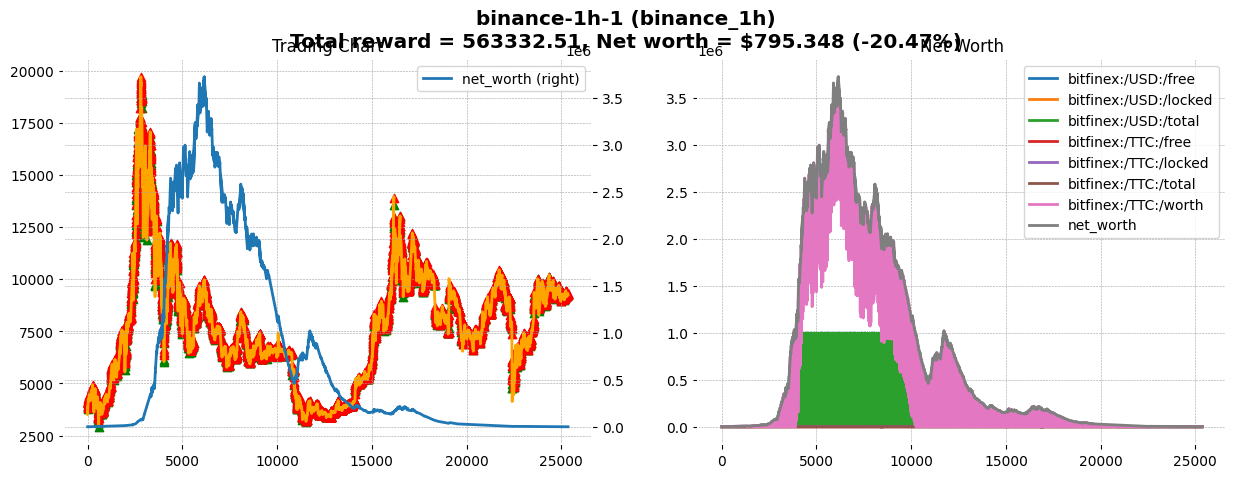

In [42]:
title = f"{experiment_name} ({selected_sample['name']})"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df}, title=title, filename=filename)

Total reward = -3850.66
Net worth = 799.8687 USD
PNL = -20.01%


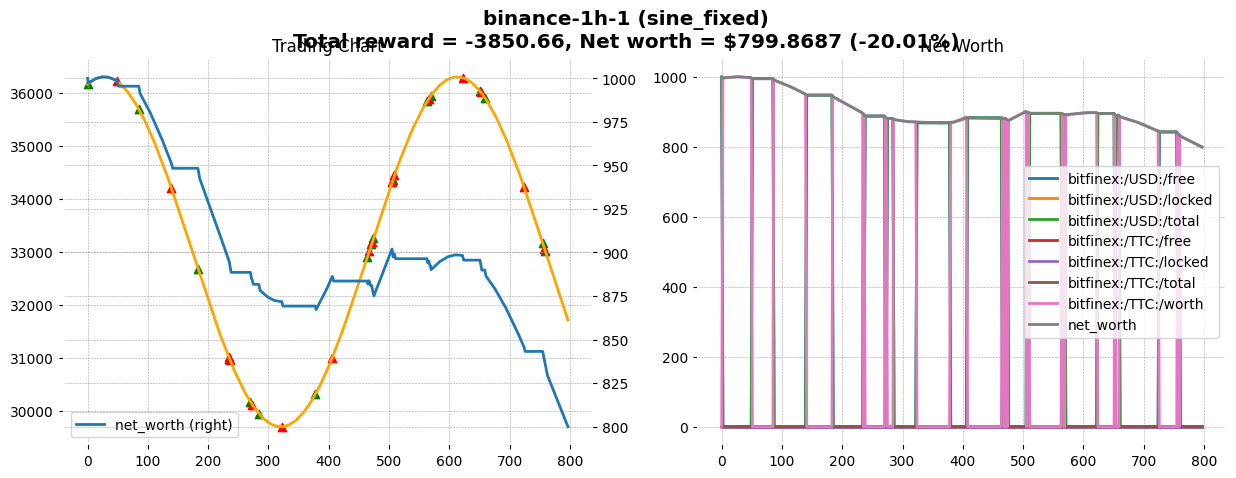

In [43]:
title = experiment_name + " (sine_fixed)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_sine_fixed}, title=title, filename=filename)

Total reward = -2840.68
Net worth = 799.7478 USD
PNL = -20.03%


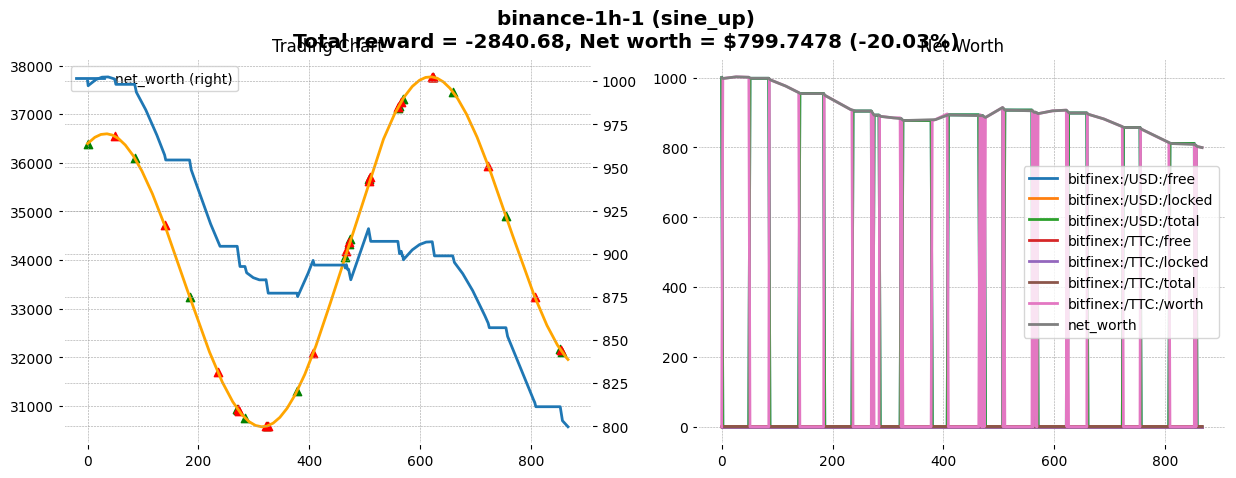

In [44]:
title = experiment_name + " (sine_up)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_sine_up}, title=title, filename=filename)

Total reward = -3808.16
Net worth = 799.48 USD
PNL = -20.05%


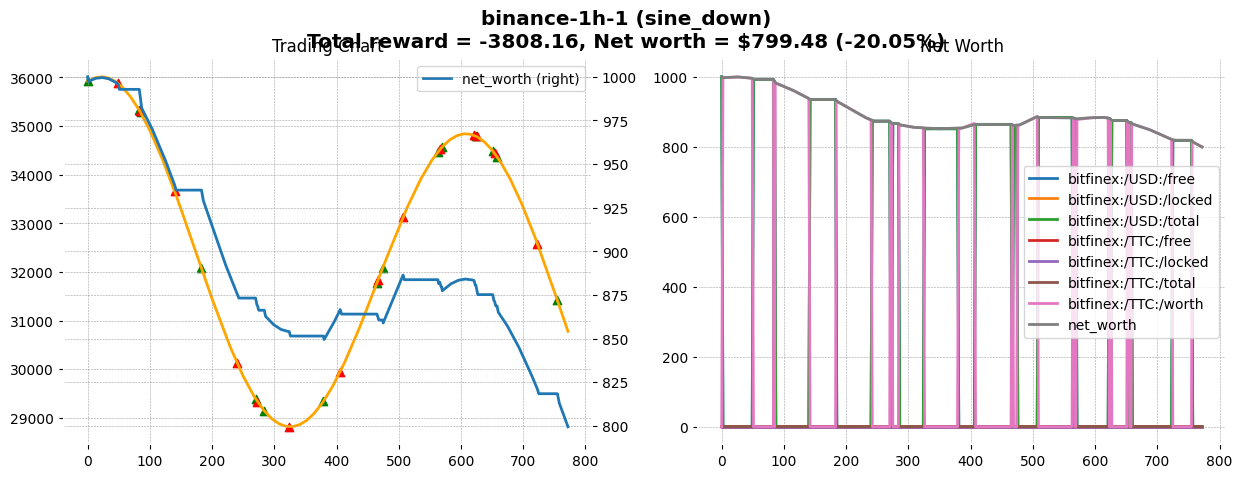

In [45]:
title = experiment_name + " (sine_down)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_sine_down}, title=title, filename=filename)

Total reward = -6853.6
Net worth = 704.4866 USD
PNL = -29.55%


/tmp/ipykernel_256698/647420900.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


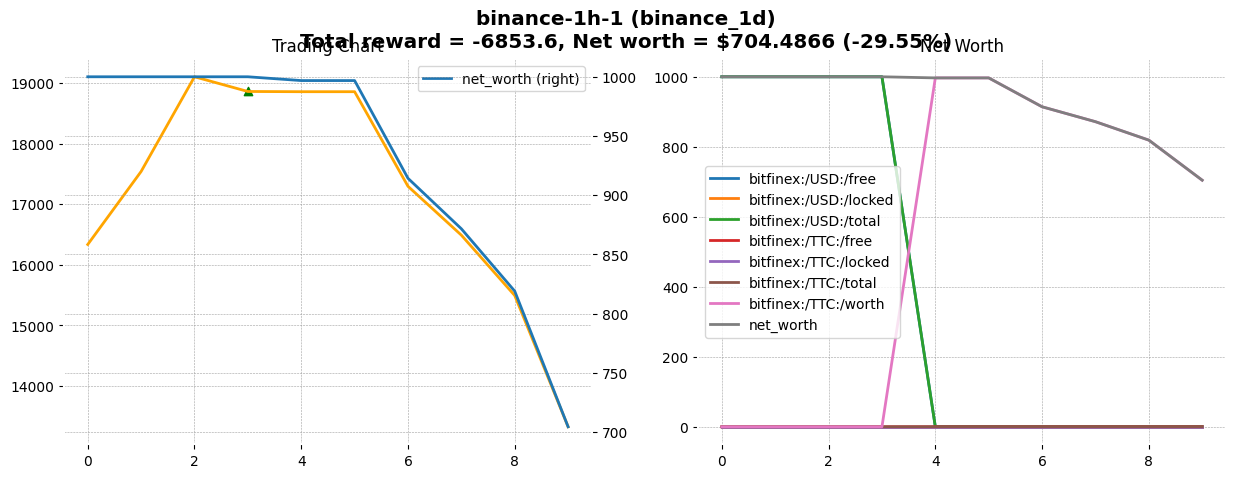

In [46]:
title = experiment_name + " (binance_1d)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_binance_1d}, title=title, filename=filename)

Total reward = 561973.23
Net worth = 799.6277 USD
PNL = -20.04%


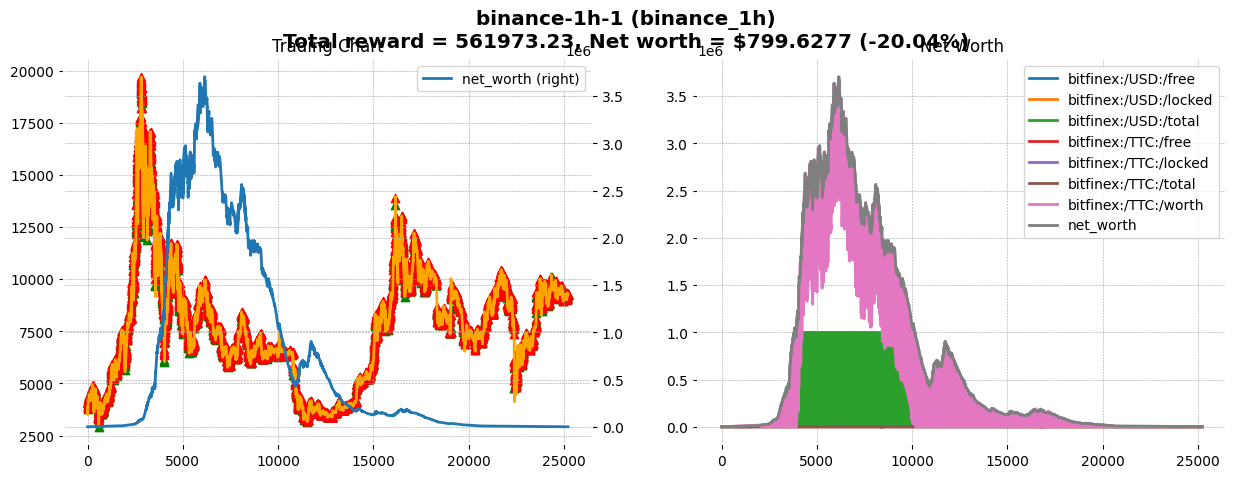

In [47]:
title = experiment_name + " (binance_1h)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_binance_1h}, title=title, filename=filename)

Total reward = 2364.41
Net worth = 790.1785 USD
PNL = -20.98%


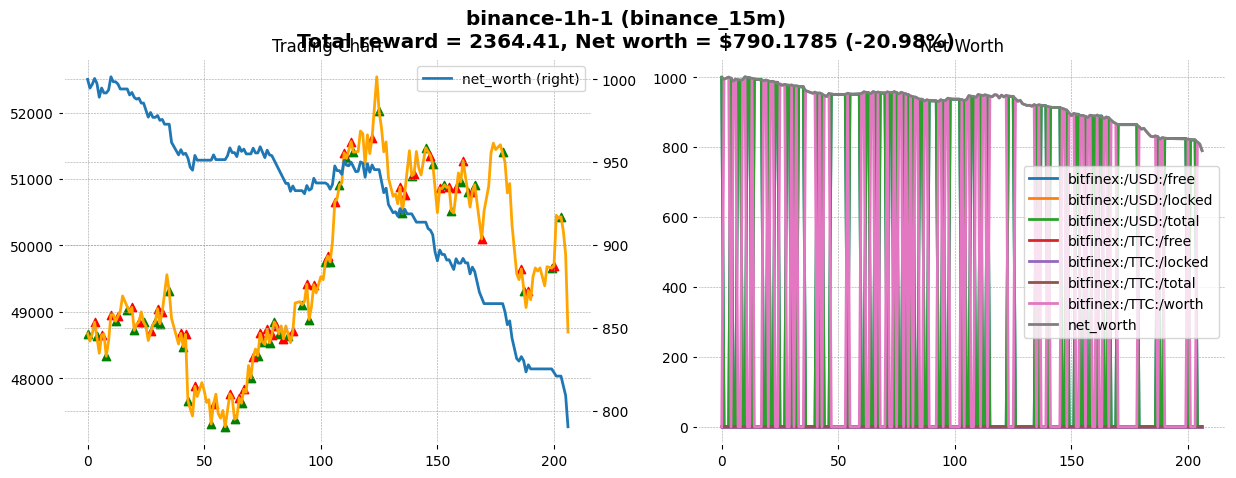

In [48]:
title = experiment_name + " (binance_15m)"
filename = checkpoint_filepath.rsplit('/',1)[0] + f'/{title}.png'
evaluate_agent(agent=agent, config={"window_size": 25, "df": df_binance_15m}, title=title, filename=filename)

## Performance and Net Worth Plotting

In [49]:
def show_performance(df, price_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Performance')

    df.plot(ax=axs[0], grid=True, fontsize=12)
    df.net_worth.plot(ax=axs[1], grid=True, legend=True)
    price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

    plt.interactive(True)
    plt.show(block=True)

In [50]:
def agent_performance():
  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)

  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {net_worth} USD")

  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {pnl} %")

In [51]:
#env.action_scheme.portfolio.performance

In [52]:
import os
os.system("shutdown -h")

Shutdown scheduled for Mon 2021-07-26 09:19:53 +08, use 'shutdown -c' to cancel.


0